In [185]:
# !pip3 install geocoder

In [186]:
import pandas as pd
import numpy as np
import datetime
from typing import Tuple
from collections import Counter

import requests
import os
import json

from PIL import Image, ImageDraw, ImageColor
from matplotlib.pyplot import imshow
import imageio

DATABASE = 'photo.csv'
PHOTO_DIR = 'photo'
GEOCODE_YANDEX_API_KEY = '9b6abe72-c629-42d6-aec0-37393d031787'
WEATHER_YANDEX_API_KEY = '7ca7b1e0-45a4-45f1-96de-2ea1a260ca8b'

In [187]:
def add_photo(photo: str, data: datetime.datetime, localion: Tuple[float, float]):
    df = pd.read_csv(DATABASE)
    df = df.append({'photo': photo, 'lat': localion[1], 'lon': localion[0], 'data': data, 'weather': {}}, ignore_index=True)
    df.to_csv(DATABASE, ignore_index=True) 

In [188]:
def get_localion_by_address(address: str) -> Tuple[float, float]:
    url = f'https://geocode-maps.yandex.ru/1.x/?apikey={GEOCODE_YANDEX_API_KEY}&geocode=${address}&format=json'
    r = requests.get(url).json()
    return list(map(float, r["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"]["Point"]["pos"].split(' ')))

print(get_localion_by_address('Санкт-Петербург, Московское шоссе, 26, к2'))

[30.341344, 59.834641]


In [189]:
def get_weather_by_localion(localion: Tuple[float, float]):
    url = f'https://api.weather.yandex.ru/v2/forecast?lon={localion[0]}&lat={localion[1]}&extra=true'
    r = requests.get(url, headers={'X-Yandex-API-Key': WEATHER_YANDEX_API_KEY}).json()
    return r['fact']
get_weather_by_localion([30.341344, 59.834641])

{'obs_time': 1633870800,
 'uptime': 1633871166,
 'temp': 12,
 'feels_like': 7,
 'icon': 'bkn_d',
 'condition': 'cloudy',
 'cloudness': 0.5,
 'prec_type': 0,
 'prec_prob': 0,
 'prec_strength': 0,
 'is_thunder': False,
 'wind_speed': 6,
 'wind_dir': 'sw',
 'pressure_mm': 766,
 'pressure_pa': 1021,
 'humidity': 62,
 'daytime': 'd',
 'polar': False,
 'season': 'autumn',
 'source': 'station',
 'accum_prec': {'3': 0.00040990175, '1': 0, '7': 0.00040990175},
 'soil_moisture': 0.3,
 'soil_temp': 11,
 'uv_index': 0,
 'wind_gust': 9.2}

In [190]:
def get_image(photo: str):
    photo_path = os.path.join(PHOTO_DIR, photo)
    img = Image.open(photo_path)
    return np.asarray(img)

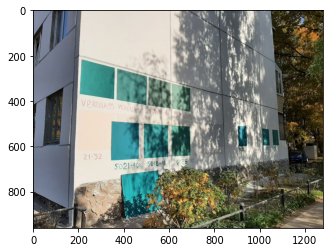

In [191]:
img = get_image('photo_2021-10-10 12.19.01.jpeg')
imshow(img)

[233.82610456 226.01550452 213.88421114] #e9e2d5 %=0.16683349609375
[114.22986108 119.9548878  125.27958111] #72777d %=0.09538248697916667
[ 99.30093172 105.07334565 112.05789976] #636970 %=0.08203206380208333
[126.37621942 133.96325926 143.32082771] #7e858f %=0.06873779296875
[85.87464794 89.70983981 88.57453452] #555958 %=0.06344319661458334
[38.0610582  34.64895503 15.08104497] #26220f %=0.061417643229166666
[18.03055496 15.81782263  5.01868528] #120f05 %=0.04940266927083333
[69.15359093 70.02554089 59.62362618] #45463b %=0.04709635416666667
[59.996404   55.34504204 30.3061462 ] #3b371e %=0.04682779947916667
[208.54297435 202.16623674 189.23206864] #d0cabd %=0.045271809895833334
[153.99043499 155.60886649 145.96048976] #999b91 %=0.0410302734375
[ 65.86399495 162.42138124 162.5935401 ] #41a2a2 %=0.036105143229166664
[29.25996625 48.95324758 51.17661011] #1d3033 %=0.03575520833333334
[178.22117047 179.27175298 169.44832529] #b2b3a9 %=0.035520833333333335
[121.00889874 112.55651146  80

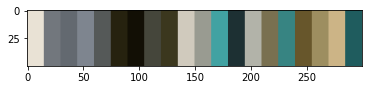

In [194]:
from sklearn.cluster import KMeans

def get_hex_from_rgb(rgb_code: np.array) -> int:
    colour = binascii.hexlify(bytearray(int(c) for c in rgb_code)).decode('ascii')
    return colour

def get_rgb_from_hex(hex: int) -> np.array:
    return ImageColor.getcolor(hex, "RGB")

def get_colors_from_photo(img: np.array, colors_count: int=20):
    clt = KMeans(n_clusters=colors_count)
    clusters = clt.fit(img.reshape(-1, 3))
    cluster_centers = clusters.cluster_centers_
    cluster_pixels_count = Counter(clusters.labels_)
    pixels_count = img.shape[0] * img.shape[1]
    
    c_img = img.reshape(-1, 3).copy()
    for i, rgb_code in enumerate(cluster_centers):
        c_img[np.where(clusters.labels_ == i)] = rgb_code
    imageio.imwrite('clusters.png', c_img.reshape(*img.shape))
    
    width=300
    palette = np.zeros((50, 300, 3), np.uint8)
    steps = width / cluster_centers.shape[0]
    
    cluster_pixels_percent, cluster_centers = zip(*list(sorted(zip([cluster_pixels_count[i] / pixels_count for i in range(len(cluster_centers))], cluster_centers), reverse=True)))
    
    for i, rgb_code in enumerate(cluster_centers): 
        palette[:, int(i * steps):(int((i + 1) * steps)), :] = rgb_code
        print(rgb_code, f'#{get_hex_from_rgb(rgb_code)}', f'%={cluster_pixels_percent[i]}')
    imshow(palette)


get_colors_from_photo(img)

In [ ]:
def get_closest_image():
    # go thrue all photoes in dataset and define closest one by weather time of the day and color
    pass 